## Machine Learning applied to identify low hemolytic Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the hemolysis model.

In [4]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [5]:
# Load meta data
meta_data = pd.read_excel("data/Cumulative_Peptide_data_PG1.xlsx", usecols=['ID', 'Sequence', '%Hemolysis'])
meta_data

,ID,Sequence,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,15.821069
...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,35.460367
92,PG-1.60,RGGRLCYCRRRFCVCVGF,36.664085
93,PG-1.25,RGWRLCYCRRRFCVCVGH,46.397292
94,PG-1.7,RRWCLCFCRRRFCVCVCR,51.181276


## Embedding Extraction

The embeddings I used for the model were computed using the ESM-2 15B model and I used the mean of the last layer as the embedding.

Here's how to exytract them using the pre-trained model from esm2.  

Download the python file extract from [esm2-github](https://github.com/facebookresearch/esm), and make sure to have a conda enviromment seted up accordinly.

Then run:  
python extract.py esm2_t48_15B_UR50D data/Cumulative_Peptide_data_PG1.fasta data/embedding/esm2_15B_PG1 --repr_layers 48 --include mean

In [6]:
# creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
data

,ID,Sequence,%Hemolysis,0,1,2,3,4,5,6,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,2.600000,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1.607281,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,3.233927,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,12.103021,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,15.821069,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,35.460367,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,-0.117476,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
92,PG-1.60,RGGRLCYCRRRFCVCVGF,36.664085,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,-0.079077,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
93,PG-1.25,RGWRLCYCRRRFCVCVGH,46.397292,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,-0.080665,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
94,PG-1.7,RRWCLCFCRRRFCVCVCR,51.181276,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,-0.059348,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


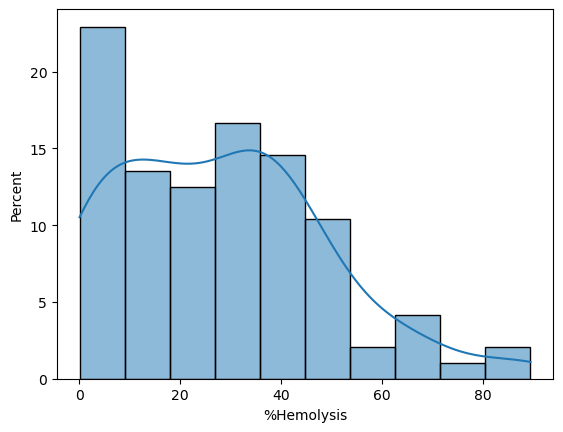

In [7]:
# plot target distribution
sns.histplot(data=data, x='%Hemolysis', bins=10, kde=True, stat='percent')
plt.show()

In [8]:
# Define target and features
data["%Hemolysis"] = data["%Hemolysis"].round(2)
target = data["%Hemolysis"]

# define features
features = data.iloc[:, meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471


## Split data into train and test sets

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### PCAs before feature selection

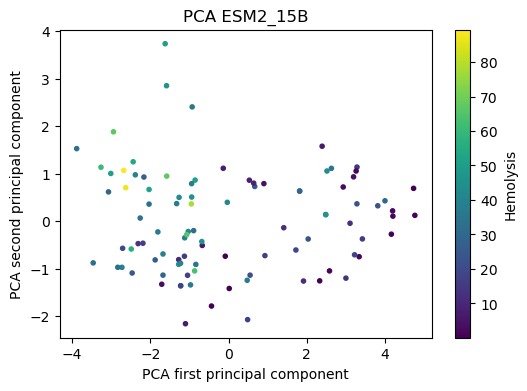

In [10]:
num_pca_components = 2
pca = PCA(num_pca_components)
X_train_pca = pca.fit_transform(features)
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=target, marker='.')
plt.title(f'PCA ESM2_15B')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Hemolysis')
plt.show()

### Selecting features by correlation

In [11]:
def get_correlated_columns(df, target, threshold):
    # correlating train target  with train set
    corr_matrix = df.corrwith(target).abs().sort_values()

    # create a list of columns with high positive or negative correlation
    correlated_columns = []
    for column in corr_matrix.index:
        if (corr_matrix[column] >= threshold) & (column not in correlated_columns):
            correlated_columns.append(column)

    return(correlated_columns)

corr_columns = get_correlated_columns(X_train, y_train, 0.6)
len(corr_columns)

164

In [11]:
# save the list to a file
# with open('models/correlated_columns_esm2_15B_hemolysis_corr06_new.pkl', 'wb') as f:
#     pickle.dump(corr_columns, f)

# load the list from the file
# with open('models/correlated_columns_esm2_15B_hemolysis_corr06_new..pkl', 'rb') as f:
#     corr_columns = pickle.load(f)

# print the loaded list
print(corr_columns)

In [12]:
# selecting features
XX_train = X_train[corr_columns]
XX_test = X_test[corr_columns]

### PCAs after feature selection 

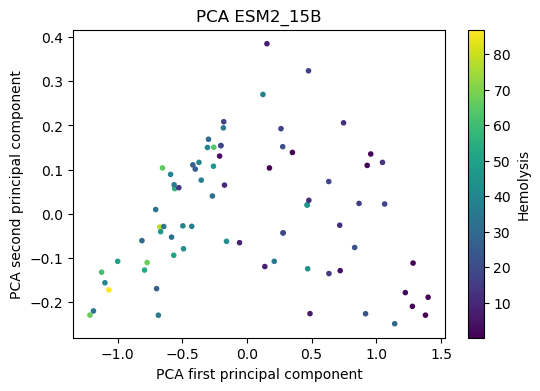

In [13]:
num_pca_components = 2
pca = PCA(num_pca_components)
X_train_pca = pca.fit_transform(XX_train)
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, marker='.')
plt.title(f'PCA ESM2_15B')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Hemolysis')
plt.show()

## Running Regression Models for testing code

In [15]:
# store the results
results = pd.DataFrame()

# Create a list of models to test
models = [LinearRegression(), Lasso(), DecisionTreeRegressor(), RandomForestRegressor(), SVR(), GradientBoostingRegressor(), XGBRegressor()]

# Create a dictionary of hyperparameters for each model
param_grid = [
    # LinearRegression
    {'fit_intercept': [True, False]}, 
    # Lasso
    {'alpha': np.arange(0.01, 1, 0.01),'max_iter': [10000, 100000]},
    # DecisionTreeRegressor
    {'max_depth': [None, 2, 3, 4, 5, 10], 'min_samples_leaf': [1,2,4]}, 
    # RandomForestRegressor
    {'n_estimators': [100, 200, 300, 500, 700], 'max_depth': [None, 2, 3, 4, 5, 10]}, 
    # SVR
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
    'gamma': ['scale', 0.1, 0.01, 0.001, 0.0001]},
    # GradientBoostingRegressor
    {'n_estimators': [100, 200, 300, 500, 700], 'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [1, 3, 5], 'alpha': [0.1, 0.3, 0.6, 0.9]},
    # XGBRegressor
    {'n_estimators': [100, 300, 700], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [1, 3, 5]}
    ]

# Iterate over the models and fit and predict using grid search
for model, param_grid in zip(models, param_grid):
    # search and train
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=10, n_jobs=10)
    grid_search.fit(XX_train, y_train)
    
    # make predictions
    train_pred = grid_search.predict(XX_train)
    y_pred = grid_search.predict(XX_test)
    
    # Model evaluation
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    model_name = grid_search.best_estimator_.__class__.__name__
    embed_name = dir_path.split('/')[-2]
    best_params = str(grid_search.best_params_)
    
    # print best scores
    print(f"Model: {model_name}, R2:{r2:.2f}, MAE:{mae:.2f}, RMSE:{np.sqrt(mae):.2f}, best params {best_params}")

    # Saving results
    res_dict = {}
    res_dict["Embedding"] = embed_name
    res_dict["model"] = model_name
    res_dict["R2_score"] = r2.round(2)
    res_dict["MAE_score"] = mae.round(2)
    res_dict["RMSE_score"] = rmse.round(2)
    res_dict["Best_params"] = best_params
    
    # updating data frame with results
    results = pd.concat([results, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)

results.to_excel('results/results_regression_hemolysis.xlsx')

Model: LinearRegression, R2:-1.44, MAE:27.43, RMSE:5.24, best params {'fit_intercept': False}
Model: Lasso, R2:0.71, MAE:10.16, RMSE:3.19, best params {'alpha': 0.06999999999999999, 'max_iter': 10000}
Model: DecisionTreeRegressor, R2:0.53, MAE:13.47, RMSE:3.67, best params {'max_depth': 3, 'min_samples_leaf': 1}
Model: RandomForestRegressor, R2:0.72, MAE:10.35, RMSE:3.22, best params {'max_depth': 4, 'n_estimators': 100}
Model: SVR, R2:0.72, MAE:10.65, RMSE:3.26, best params {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Model: GradientBoostingRegressor, R2:0.71, MAE:9.84, RMSE:3.14, best params {'alpha': 0.1, 'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 700}
Model: XGBRegressor, R2:0.74, MAE:9.81, RMSE:3.13, best params {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


## Results Visualization

In [16]:
results = pd.read_excel('results/results_regression_hemolysis.xlsx', index_col=0)
results

,Embedding,model,R2_score,MAE_score,RMSE_score,Best_params
0,esm2_15B_PG1,LinearRegression,-1.44,27.43,35.65,{'fit_intercept': False}
1,esm2_15B_PG1,Lasso,0.71,10.16,12.40,"{'alpha': 0.06999999999999999, 'max_iter': 10000}"
2,esm2_15B_PG1,DecisionTreeRegressor,0.53,13.47,15.61,"{'max_depth': 3, 'min_samples_leaf': 1}"
3,esm2_15B_PG1,RandomForestRegressor,0.72,10.35,12.06,"{'max_depth': 4, 'n_estimators': 100}"
4,esm2_15B_PG1,SVR,0.72,10.65,12.13,"{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}"
5,esm2_15B_PG1,GradientBoostingRegressor,0.71,9.84,12.24,"{'alpha': 0.1, 'learning_rate': 0.01, 'max_dep..."
6,esm2_15B_PG1,XGBRegressor,0.74,9.81,11.75,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."


### Model performances

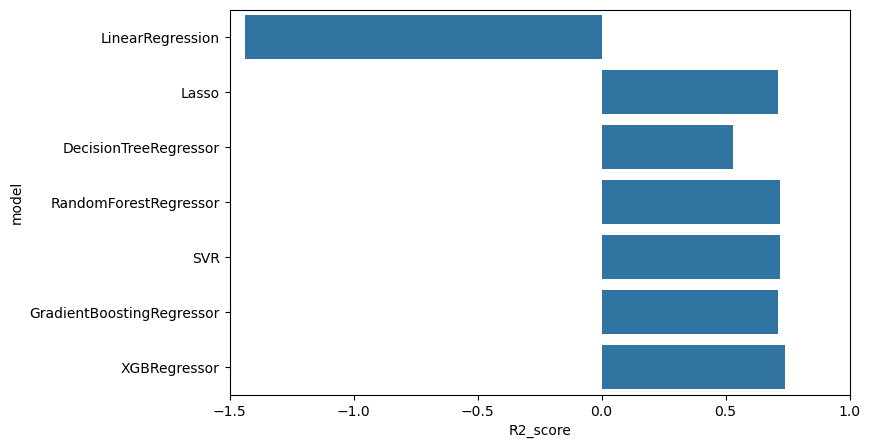

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results, y='model', x='R2_score')
plt.xlim(-1.5, 1)
plt.show()

## Fine Tunning Model with best hyperparameter found with Gridsearch

To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation. If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting. In such cases, it may be necessary to adjust the hyperparameters of the model or to use a more complex kernel function.

The C parameter controls the trade-off between achieving a low training error and a low testing error. 

A linear kernel is a simple kernel function that can help to avoid overfitting by creating a linear decision boundary. 


### SVR

In [18]:
# train support vector machine regressor
SVR = SVR(
    C=100, 
    gamma='scale',
    kernel='linear',
    )

# fined tuned SVR performance
SVR.fit(XX_train, y_train)

# print R2 score
print(f'R2 score: {SVR.score(XX_test, y_test):.2f}')

R2 score: 0.72


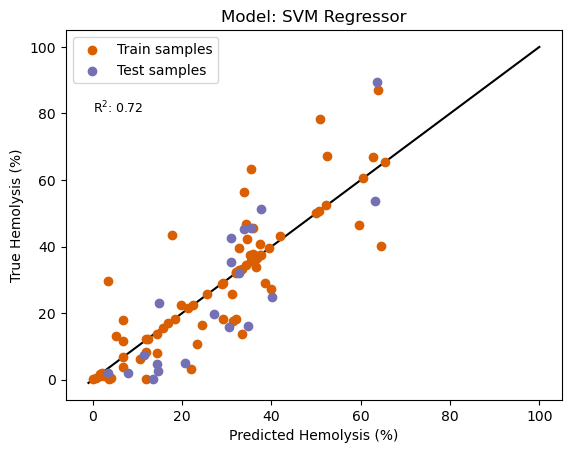

In [19]:
train_pred = SVR.predict(XX_train)
y_pred = SVR.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Hemolysis (%)")
plt.ylabel("True Hemolysis (%)")
plt.plot([-1, 100], [-1, 100], c='k', zorder=0) 
plt.text(0, 80, f'R$^2$: {SVR.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

### Lasso

In [20]:
model = Lasso(
    alpha=0.069,
    max_iter=10000    
)

# fined tuned model performance
model.fit(XX_train, y_train)

# print R2 score
print(f'R2 score: {model.score(XX_test, y_test):.2f}')

R2 score: 0.71


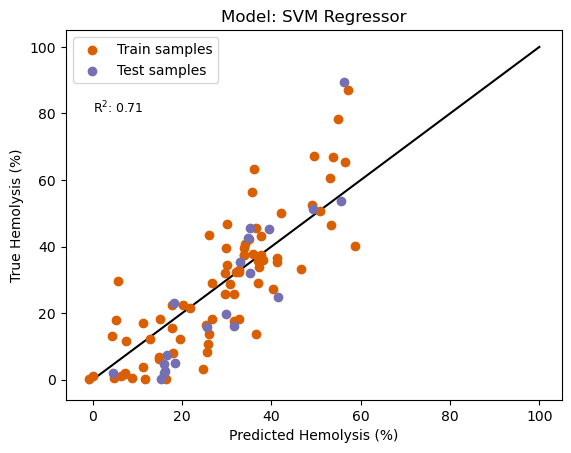

In [21]:
train_pred = model.predict(XX_train)
y_pred = model.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Hemolysis (%)")
plt.ylabel("True Hemolysis (%)")
plt.plot([-1, 100], [-1, 100], c='k', zorder=0) 
plt.text(0, 80, f'R$^2$: {model.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

### Random Forest

In [22]:
# train RF regressor
model = RandomForestRegressor(
    max_depth=10, 
    n_estimators=200,
    )

# fined tuned model performance
model.fit(XX_train, y_train)

# print R2 score
print(f'R2 score: {model.score(XX_test, y_test):.2f}')

R2 score: 0.71


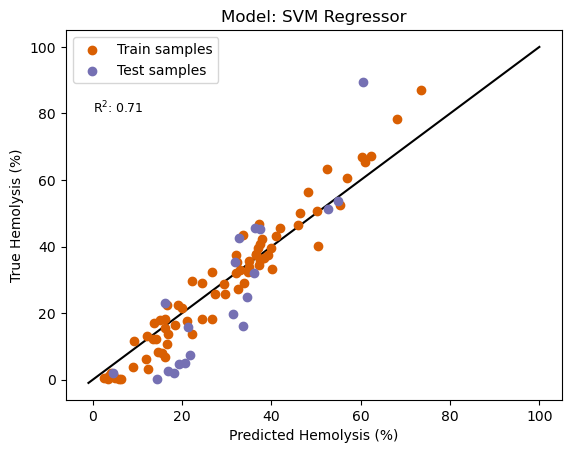

In [23]:
train_pred = model.predict(XX_train)
y_pred = model.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Hemolysis (%)")
plt.ylabel("True Hemolysis (%)")
plt.plot([-1, 100], [-1, 100], c='k', zorder=0) 
plt.text(0, 80, f'R$^2$: {model.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

### GradientBoosting Regressor

In [24]:
# train a gradient boosting classifier
model = GradientBoostingRegressor(
    alpha=0.3, 
    learning_rate=0.01,
    max_depth=1,
    n_estimators=700
    )

# fined tuned model performance
model.fit(XX_train, y_train)

# print R2 score
print(f'R2 score: {model.score(XX_test, y_test):.2f}')

R2 score: 0.71


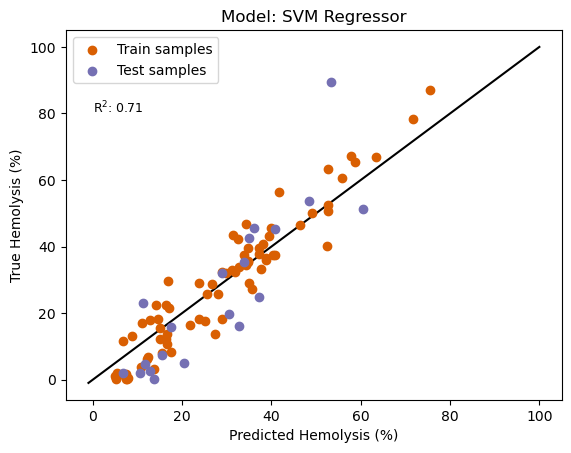

In [25]:
train_pred = model.predict(XX_train)
y_pred = model.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Hemolysis (%)")
plt.ylabel("True Hemolysis (%)")
plt.plot([-1, 100], [-1, 100], c='k', zorder=0) 
plt.text(0, 80, f'R$^2$: {model.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

### XGB regressor

In [26]:
# train XG boost regressor
model = XGBRegressor(
    learning_rate=0.05,
    max_depth=1,
    n_estimators=100
    )

# fined tuned model performance
model.fit(XX_train, y_train)

# print R2 score
print(f'R2 score: {model.score(XX_test, y_test):.2f}')

R2 score: 0.71


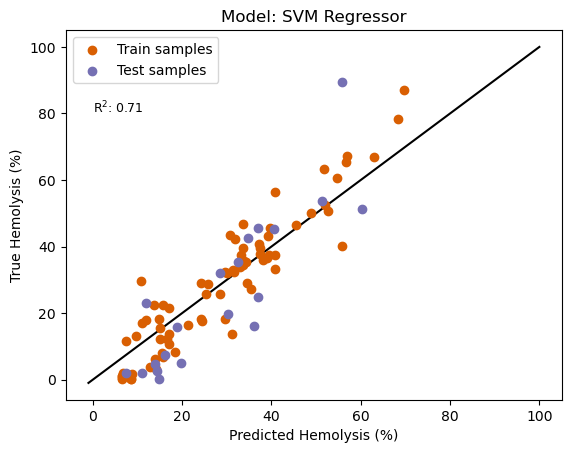

In [27]:
train_pred = model.predict(XX_train)
y_pred = model.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Hemolysis (%)")
plt.ylabel("True Hemolysis (%)")
plt.plot([-1, 100], [-1, 100], c='k', zorder=0) 
plt.text(0, 80, f'R$^2$: {model.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

# Save the models
SVR and lasso has less change to be overfitting

In [28]:
#pickle.dump(SVR, open('models/model_SVR_esm2_15B_SEL_regression_corr06_new.pkl', 'wb'))